In [32]:
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report
from utils import create_param_list, create_train_data_hold_out, create_train_data_CV, inference
from sklearn.model_selection import KFold

# import warnings
# warnings.filterwarnings('ignore')

torch.manual_seed(3407)

In [33]:
nconf = 31
ndata = 990
L = 64
T_cr = 2.269  # critical temp for 2d ising
t_start = 2.1
exclude_T = (2.23, 2.28)

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Ising")
# print(prm_list)
print(f"データ数:{nconf*ndata}")

データ数:30690


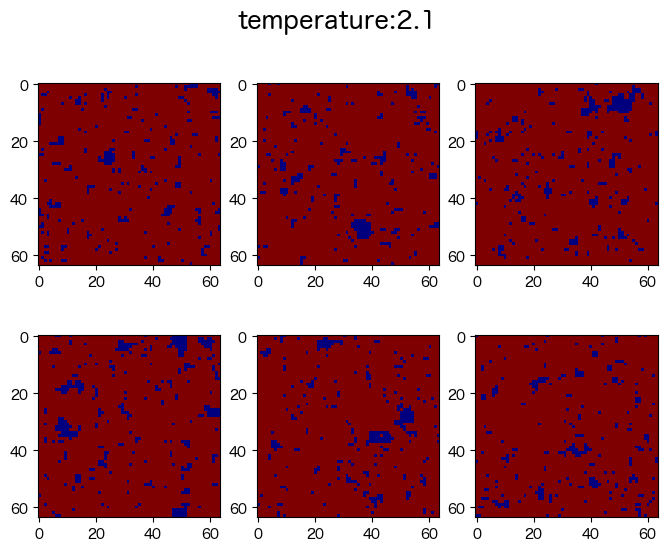

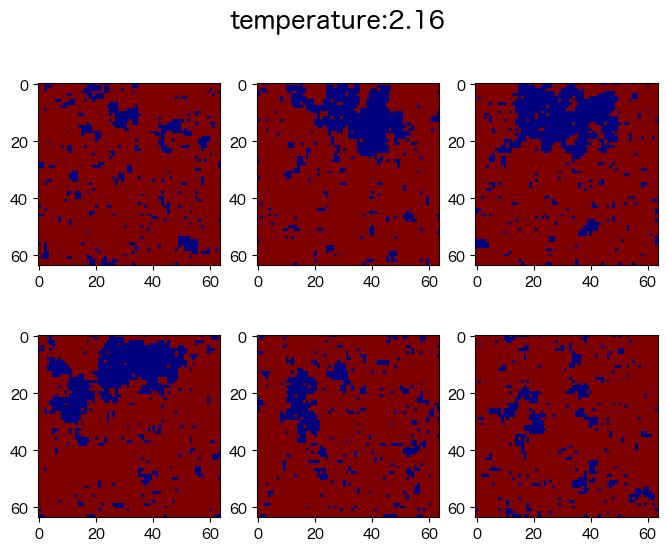

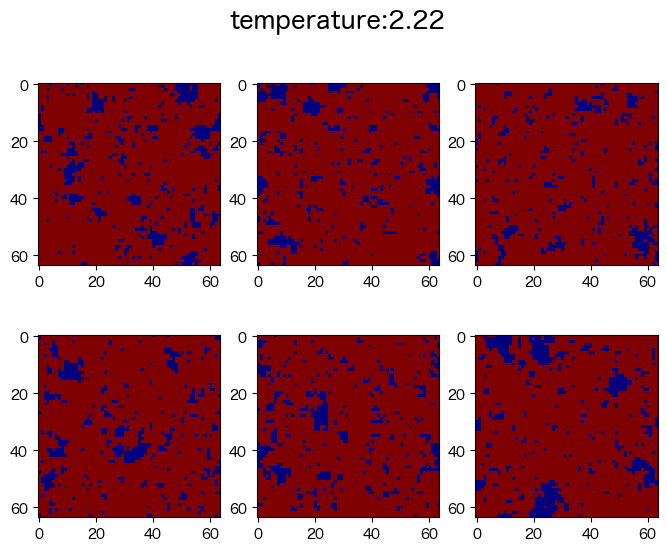

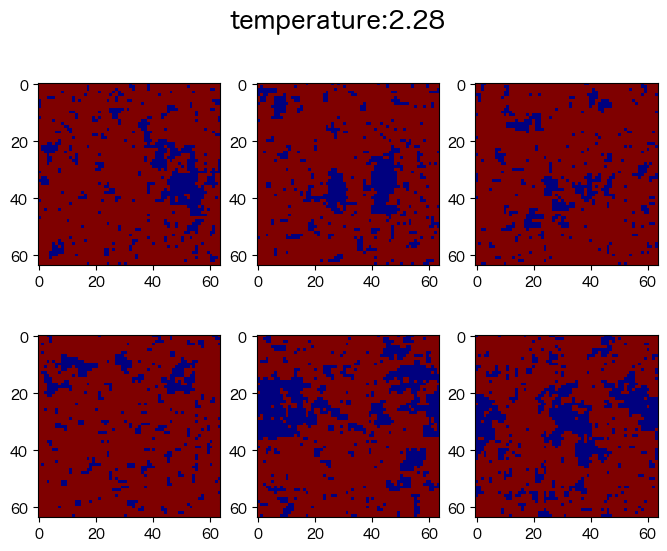

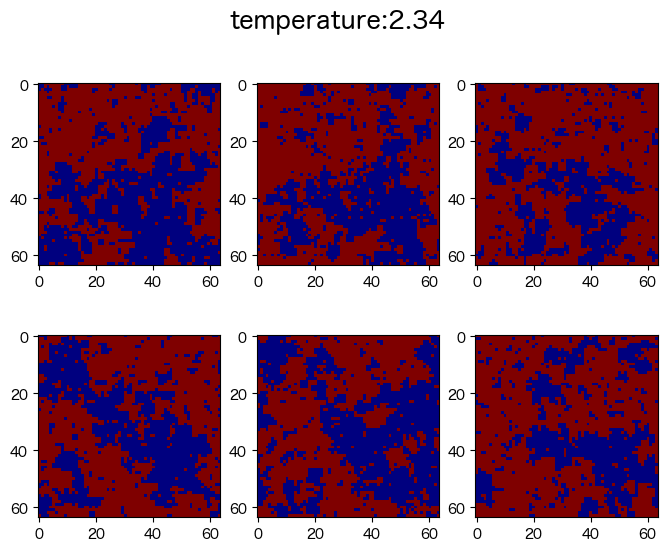

In [34]:
# 可視化
row = 2  # 行数
col = 3  # 列数

for num in range(0, 30, 6):
    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8, 6))
    fig.suptitle(f"temperature:{prm_list[num][0]}", fontsize=18, color='black')
    for iconf in range(6):
        _r = iconf//col
        _c = iconf % col
        file = f"{prm_list[num][1]}{iconf}.npy"
        sc = np.load(file)
        ax[_r,_c].imshow(sc, interpolation='nearest', vmin=0, vmax=1, cmap='jet')

In [37]:
# hold out
dataset, _ = create_train_data_CV(
    prm_list, 
    ndata, 
    T_cr, 
    total_label=2, 
    L=L, 
    model_name="2d_Ising",
    exclude_T=exclude_T, 
    # correlation_configuration=True
)
_, _, test_dataset = create_train_data_hold_out(
    prm_list, 
    ndata, 
    T_cr, 
    exclude_T=exclude_T, 
    total_label=2, 
    L=L, 
    model_name="2d_Ising",
    # correlation_configuration=True
)
BATCH_SIZE=4096
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("dataset.shape = ", len(dataset))
print("test_dataset.shape = ", len(test_dataset))

dataset.shape =  24750
test_dataset.shape =  13365


In [23]:
class CNNClassifier(nn.Module):
    def __init__(self, target_size):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(14*14*128, 96)
        self.fc2 = nn.Linear(96, 64)
        self.fc3 = nn.Linear(64, target_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        # x = self.dropout1(x)
        x = self.relu(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        # x = self.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        # x = self.dropout2(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

mps is available.
FOLD 1
--------------------------------
Epoch: 60, Validation loss: 2.3544598107386118e-05, Accuracy: 97.67272727272727%
Classification Report:
               precision    recall  f1-score   support

           0     0.9657    0.9902    0.9778      6402
           1     0.9892    0.9623    0.9756      5973

    accuracy                         0.9767     12375
   macro avg     0.9774    0.9762    0.9767     12375
weighted avg     0.9770    0.9767    0.9767     12375



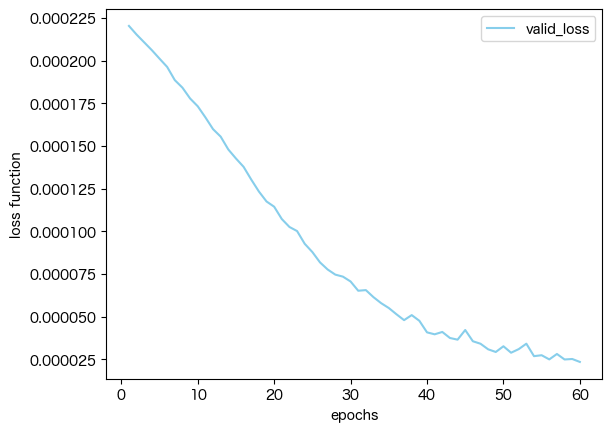

FOLD 2
--------------------------------
Epoch: 60, Validation loss: 2.6460592192832868e-05, Accuracy: 97.76969696969697%
Classification Report:
               precision    recall  f1-score   support

           0     0.9682    0.9898    0.9789      6468
           1     0.9885    0.9644    0.9763      5907

    accuracy                         0.9777     12375
   macro avg     0.9784    0.9771    0.9776     12375
weighted avg     0.9779    0.9777    0.9777     12375



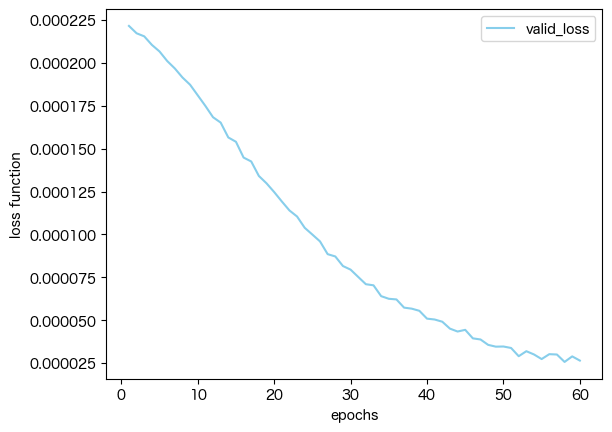

K-FOLD CROSS VALIDATION RESULTS FOR 2 FOLDS
Done.


In [30]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    print("mps is available.")

# hyper parameter
LEARNING_RATE = 0.00001
target_size = 2
grad_clip = 0.1
norm_type = 2
epochs = 60
k_folds = 2
kfold = KFold(n_splits=k_folds, shuffle=True)
niter = 100

for fold, (train_data, valid_data) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    train_subsampler = SubsetRandomSampler(train_data)
    valid_subsampler = SubsetRandomSampler(valid_data)

    train_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valid_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=valid_subsampler)

    model = CNNClassifier(target_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    vaild_loss_list, accuracy_list = [], []
    for epoch in range(epochs):
        model.train()
        # train_loss = 0
        for data, _, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.type(torch.long))
            # train_loss += loss.item()
            loss.backward()
            del loss
            nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=grad_clip, norm_type=norm_type)
            optimizer.step()
        # train_loss_list.append(train_loss)

        model.eval()
        with torch.no_grad():
            valid_loss = 0
            correct = 0
            answer, prediction = [], []
            for data, _, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                valid_loss += criterion(output, target.type(torch.long)).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                prediction += list(pred.cpu().numpy())
                answer += list(target.cpu().numpy())

        valid_loss /= len(valid_loader.sampler.indices)
        accuracy = 100 * correct / len(valid_loader.sampler.indices)

        vaild_loss_list.append(valid_loss)
        accuracy_list.append(accuracy)
        if epoch == epochs - 1:
            print(f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {accuracy}%')
            print("Classification Report:\n", classification_report(answer, prediction, digits=4))
    plt.xlabel('epochs')
    plt.ylabel('loss function')
    # plt.plot(np.arange(1, epochs+1), train_loss_list, label="train_loss", color="orange")
    plt.plot(np.arange(1, epochs+1), vaild_loss_list, label="valid_loss", color="skyblue")
    plt.legend()
    plt.show()
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print("Done.")

In [25]:
# torch.save(model, "../models/2d_Ising_model_classifier.pth")

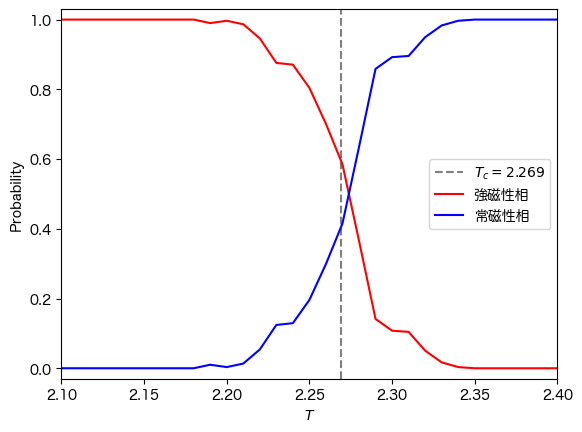

In [38]:
model = torch.load("../models/2d_Ising_spin_list/2d_Ising_model_classifier_0.pth")
# model = torch.load("../models/2d_Ising_config/2d_Ising_model_classifier_0.pth")
model.eval()
answer_test, prediction_test, temps = [], [], []
with torch.no_grad():
    for data, temp, target in test_loader:
        data = data.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=False)
        prediction_test += list(pred.cpu().numpy())
        answer_test += list(target.cpu().numpy())
        temps += list(temp.cpu().numpy())
xs, y1s, y2s = inference(len(test_dataset), temps, prediction_test, target_size)
plt.axvline(x=T_cr, ymin=0, ymax=1, ls="dashed", color="gray", label=r"$T_c={}$".format(T_cr))
plt.xlim(t_start,t_end)
plt.ylim(-0.03,1.03)
plt.plot(xs, y1s, label=r"強磁性相", color="red")
plt.plot(xs, y2s, label=r"常磁性相", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Probability")
plt.show()